# Inventory Management EDA

This notebook explores the cleaned inventory management tables in `data/processed/clean`.
Outputs are written to `docs/eda/plots` and `docs/eda/tables`.

Notes and findings are added inline in markdown cells below each section.

In [9]:
from __future__ import annotations

from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

CHUNK_SIZE = 200_000


def find_repo_root(start: Path) -> Path:
    for parent in [start] + list(start.parents):
        candidate = parent / "data" / "processed" / "clean"
        if candidate.exists():
            return parent
    raise FileNotFoundError("Could not locate data/processed/clean from notebook path")


REPO_ROOT = find_repo_root(Path.cwd())
CLEAN_DIR = REPO_ROOT / "data" / "processed" / "clean"
PLOTS_DIR = REPO_ROOT / "docs" / "eda" / "plots"
TABLES_DIR = REPO_ROOT / "docs" / "eda" / "tables"

PLOTS_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)


def parse_datetime(series: pd.Series | None, index: pd.Index | None = None) -> pd.Series:
    if series is None:
        return pd.Series(pd.NaT, index=index)
    if series.dtype == "datetime64[ns, UTC]":
        return series
    if series.dtype == object or pd.api.types.is_string_dtype(series):
        parsed = pd.to_datetime(series, errors="coerce", utc=True)
        if parsed.notna().mean() >= 0.6:
            return parsed
    numeric = pd.to_numeric(series, errors="coerce")
    if numeric.notna().mean() < 0.6:
        return pd.Series(pd.NaT, index=series.index)
    max_value = numeric.dropna().max()
    if max_value > 1e12:
        return pd.to_datetime(numeric, unit="ms", errors="coerce", utc=True)
    return pd.to_datetime(numeric, unit="s", errors="coerce", utc=True)


def dataset_inventory() -> pd.DataFrame:
    rows = []
    for path in sorted(CLEAN_DIR.glob("*.csv")):
        try:
            sample = pd.read_csv(path, nrows=5)
            columns = len(sample.columns)
        except Exception:
            columns = 0
        rows.append({
            "dataset": path.name,
            "size_bytes": path.stat().st_size,
            "columns": columns,
        })
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(by="size_bytes", ascending=False)
    df.to_csv(TABLES_DIR / "dataset_inventory.csv", index=False)
    return df


inventory_df = dataset_inventory()
inventory_df.head(10)

,dataset,size_bytes,columns
13,fct_cash_balances.csv,379249850,15
16,fct_order_items.csv,304915522,25
17,fct_orders.csv,89612366,43
3,dim_items.csv,17759272,38
10,dim_users.csv,12253695,43
18,most_ordered.csv,4100688,7
5,dim_menu_items.csv,2775657,12
0,dim_add_ons.csv,2434345,14
6,dim_places.csv,2177709,192
15,fct_invoice_items.csv,347335,10


## Data inventory notes

- Largest tables: `fct_cash_balances`, `fct_order_items`, `fct_orders` (100MB+ each in cleaned form).
- Many dimension tables are small; `dim_places` has wide schema (192 columns).
- `fct_inventory_reports` is effectively empty (72 bytes) in this subset.

In [10]:
# Orders overview (chunked)
orders_path = CLEAN_DIR / "fct_orders.csv"

daily_count = defaultdict(int)
daily_revenue = defaultdict(float)
channel_counts = defaultdict(int)
type_counts = defaultdict(int)
basket_samples = []

for chunk in pd.read_csv(orders_path, chunksize=CHUNK_SIZE, low_memory=False):
    created = None
    if "created_dt" in chunk.columns:
        created = parse_datetime(chunk["created_dt"])
    elif "created" in chunk.columns:
        created = parse_datetime(chunk["created"])
    if created is None:
        continue
    chunk = chunk.copy()
    chunk["created_dt"] = created

    chunk["total_amount"] = pd.to_numeric(chunk.get("total_amount"), errors="coerce").fillna(0)
    chunk["day"] = chunk["created_dt"].dt.date

    grouped = chunk.groupby("day").agg(order_count=("id", "count"), revenue=("total_amount", "sum"))
    for day, row in grouped.iterrows():
        daily_count[day] += int(row["order_count"])
        daily_revenue[day] += float(row["revenue"])

    if "channel" in chunk.columns:
        for key, value in chunk["channel"].fillna("Unknown").value_counts().items():
            channel_counts[key] += int(value)
    if "type" in chunk.columns:
        for key, value in chunk["type"].fillna("Unknown").value_counts().items():
            type_counts[key] += int(value)

    sample = chunk["total_amount"].dropna()
    if len(sample) > 0:
        basket_samples.append(sample.sample(frac=0.02, random_state=42))

daily_df = pd.DataFrame({
    "date": list(daily_count.keys()),
    "order_count": list(daily_count.values()),
    "revenue": [daily_revenue[day] for day in daily_count.keys()],
}).sort_values("date")

daily_df.to_csv(TABLES_DIR / "orders_daily.csv", index=False)

channel_df = pd.DataFrame({"channel": list(channel_counts.keys()), "count": list(channel_counts.values())})
type_df = pd.DataFrame({"type": list(type_counts.keys()), "count": list(type_counts.values())})
channel_df.to_csv(TABLES_DIR / "orders_by_channel.csv", index=False)
type_df.to_csv(TABLES_DIR / "orders_by_type.csv", index=False)

basket_df = pd.concat(basket_samples).to_frame(name="total_amount") if basket_samples else pd.DataFrame(columns=["total_amount"])
basket_df.to_csv(TABLES_DIR / "basket_samples.csv", index=False)

daily_df.head()

,date,order_count,revenue
0,2021-02-12,9,2890.0
1,2021-02-13,1,195.0
2,2021-02-14,2,149.0
3,2021-02-15,2,198.0
4,2021-02-16,5,216.0


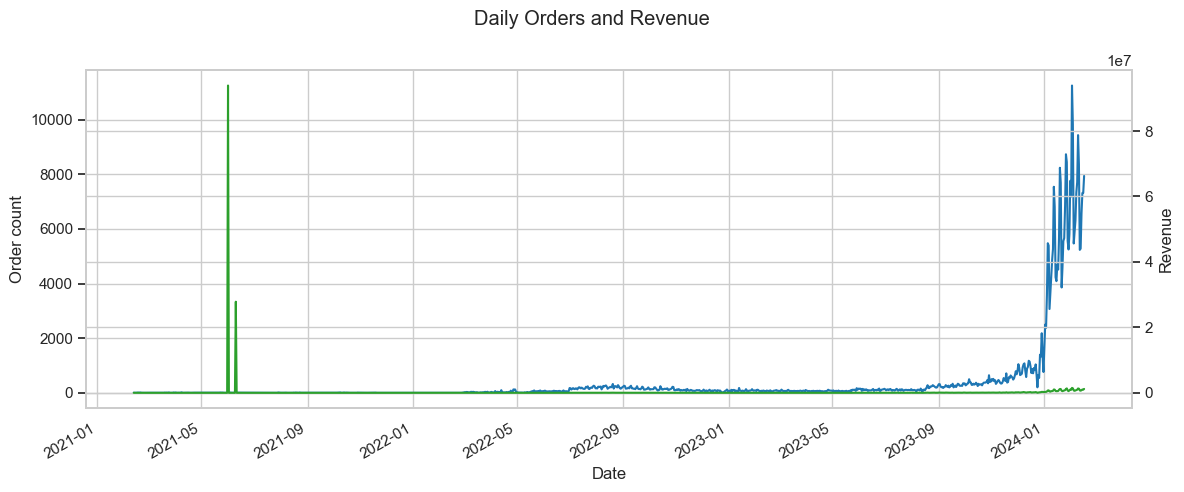

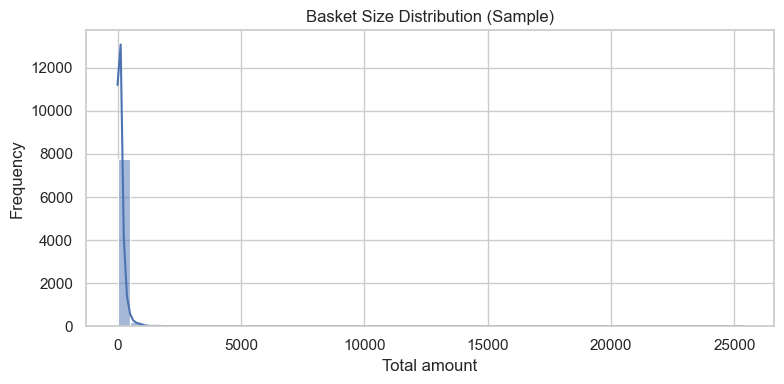

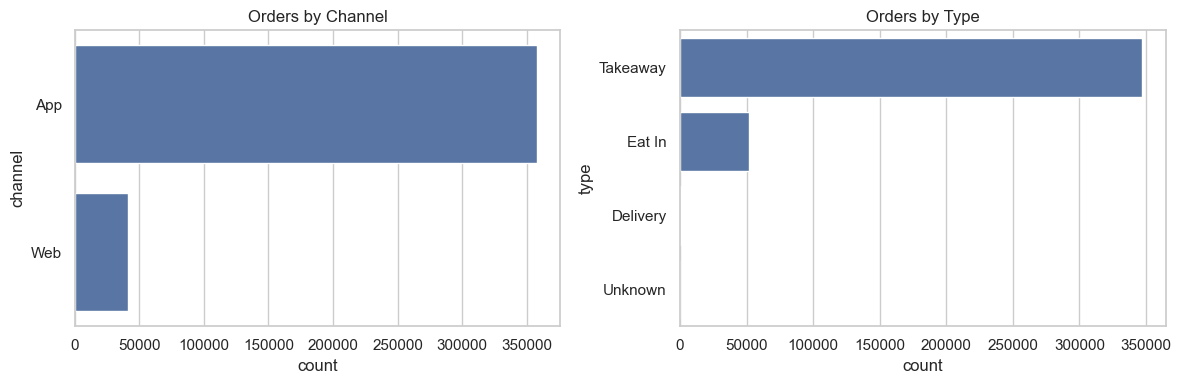

In [11]:
# Plot daily orders and revenue
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()

ax1.plot(daily_df["date"], daily_df["order_count"], color="tab:blue", label="Orders")
ax2.plot(daily_df["date"], daily_df["revenue"], color="tab:green", label="Revenue")

ax1.set_xlabel("Date")
ax1.set_ylabel("Order count")
ax2.set_ylabel("Revenue")
fig.autofmt_xdate()

fig.suptitle("Daily Orders and Revenue")
fig.tight_layout()
fig.savefig(PLOTS_DIR / "orders_daily_count_revenue.png", dpi=150)
plt.show()

# Plot basket size distribution
plt.figure(figsize=(8, 4))
sns.histplot(basket_df["total_amount"], bins=50, kde=True)
plt.title("Basket Size Distribution (Sample)")
plt.xlabel("Total amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "basket_size_distribution.png", dpi=150)
plt.show()

# Plot channel and type breakdown
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=channel_df.sort_values("count", ascending=False), x="count", y="channel", ax=axes[0])
axes[0].set_title("Orders by Channel")
sns.barplot(data=type_df.sort_values("count", ascending=False), x="count", y="type", ax=axes[1])
axes[1].set_title("Orders by Type")
fig.tight_layout()
fig.savefig(PLOTS_DIR / "orders_channel_type_breakdown.png", dpi=150)
plt.show()

## Orders notes

- Date coverage in daily aggregates runs from 2021-02-12 to 2024-02-16.
- Channel mix is heavily App-driven: App 358,321 vs Web 41,489 (~89.7% App).
- Order type is dominated by Takeaway (347,397), with Eat In (51,964), Delivery (428) and Unknown (21).
- Daily order volume and revenue ramp sharply in late 2023 into early 2024; earlier periods are much smaller.
- Basket size distribution is strongly right-skewed with a long tail; consider winsorizing/log-scaling for modeling.
- Large spikes appear in early 2021; likely outliers or data artifacts to review before forecasting.

## Data quality and outlier handling

This section applies an IQR-based (3x) outlier filter to key numeric fields and recomputes core aggregates for EDA views.

In [17]:
def iqr_bounds(values: pd.Series, multiplier: float = 3.0) -> tuple[float, float]:
    values = pd.to_numeric(values, errors="coerce").dropna()
    if values.empty:
        return (np.nan, np.nan)
    q1, q3 = np.percentile(values, [25, 75])
    iqr = q3 - q1
    return (q1 - multiplier * iqr, q3 + multiplier * iqr)


def sample_numeric_from_csv(
    path: Path,
    column: str,
    sample_per_chunk: int = 2000,
) -> pd.Series:
    samples = []
    for chunk in pd.read_csv(path, chunksize=CHUNK_SIZE, low_memory=False):
        if column not in chunk.columns:
            continue
        col = pd.to_numeric(chunk[column], errors="coerce").dropna()
        if col.empty:
            continue
        if len(col) > sample_per_chunk:
            col = col.sample(n=sample_per_chunk, random_state=42)
        samples.append(col)
    if not samples:
        return pd.Series(dtype="float64")
    return pd.concat(samples, ignore_index=True)


orders_total_sample = sample_numeric_from_csv(orders_path, "total_amount")
orders_low, orders_high = iqr_bounds(orders_total_sample, multiplier=3.0)

orders_outlier_counts = []
filtered_daily_count = defaultdict(int)
filtered_daily_revenue = defaultdict(float)
filtered_basket_samples = []

for chunk in pd.read_csv(orders_path, chunksize=CHUNK_SIZE, low_memory=False):
    created = None
    if "created_dt" in chunk.columns:
        created = parse_datetime(chunk["created_dt"], index=chunk.index)
    elif "created" in chunk.columns:
        created = parse_datetime(chunk["created"], index=chunk.index)
    if created is None:
        continue

    chunk = chunk.copy()
    chunk["created_dt"] = created
    chunk["total_amount"] = pd.to_numeric(chunk.get("total_amount"), errors="coerce")

    inlier_mask = chunk["total_amount"].between(orders_low, orders_high)
    orders_outlier_counts.append(
        {
            "total_rows": int(len(chunk)),
            "outliers": int((~inlier_mask).sum()),
            "inliers": int(inlier_mask.sum()),
        }
    )

    filtered = chunk.loc[inlier_mask].copy()
    filtered["day"] = filtered["created_dt"].dt.date
    grouped = filtered.groupby("day").agg(
        order_count=("id", "count"),
        revenue=("total_amount", "sum"),
    )
    for day, row in grouped.iterrows():
        filtered_daily_count[day] += int(row["order_count"])
        filtered_daily_revenue[day] += float(row["revenue"])

    sample = filtered["total_amount"].dropna()
    if len(sample) > 0:
        sample = sample.sample(frac=0.02, random_state=42)
        filtered_basket_samples.append(sample)

orders_filtered_daily_df = pd.DataFrame({
    "date": list(filtered_daily_count.keys()),
    "order_count": list(filtered_daily_count.values()),
    "revenue": [filtered_daily_revenue[day] for day in filtered_daily_count.keys()],
}).sort_values("date")

orders_filtered_daily_df.to_csv(
    TABLES_DIR / "orders_daily_filtered.csv", index=False
)

orders_outlier_df = pd.DataFrame(orders_outlier_counts)
orders_outlier_df.to_csv(TABLES_DIR / "orders_outlier_counts.csv", index=False)

orders_bounds_df = pd.DataFrame([
    {
        "metric": "total_amount",
        "lower": orders_low,
        "upper": orders_high,
    }
])
orders_bounds_df.to_csv(TABLES_DIR / "orders_outlier_bounds.csv", index=False)

filtered_basket_df = (
    pd.concat(filtered_basket_samples).to_frame(name="total_amount")
    if filtered_basket_samples
    else pd.DataFrame(columns=["total_amount"])
)
filtered_basket_df.to_csv(
    TABLES_DIR / "basket_samples_filtered.csv", index=False
)

orders_bounds_df

,metric,lower,upper
0,total_amount,-300.0,505.0


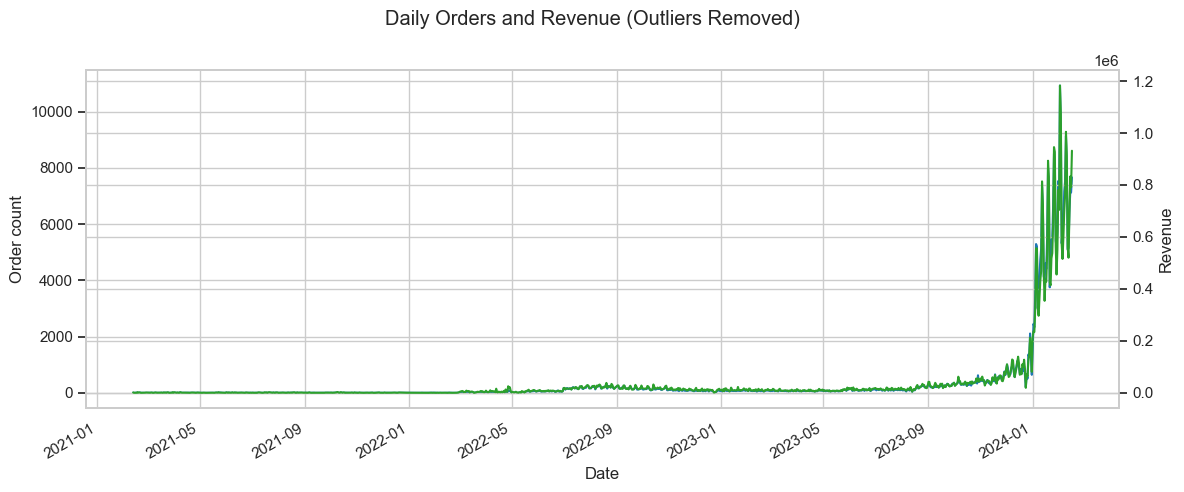

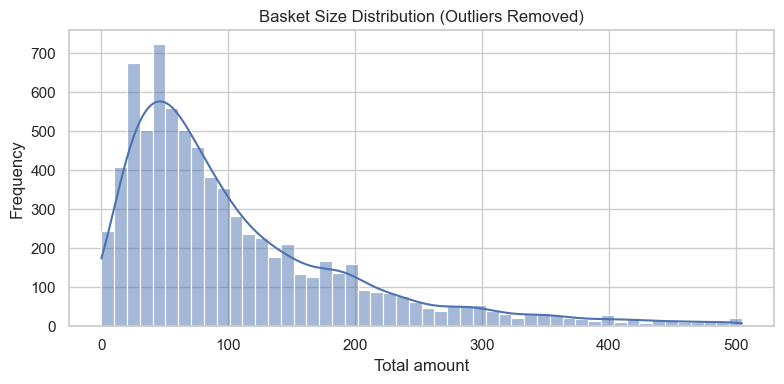

In [18]:
# Filtered order plots (outliers removed)
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()

ax1.plot(
    orders_filtered_daily_df["date"],
    orders_filtered_daily_df["order_count"],
    color="tab:blue",
    label="Orders",
)
ax2.plot(
    orders_filtered_daily_df["date"],
    orders_filtered_daily_df["revenue"],
    color="tab:green",
    label="Revenue",
)

ax1.set_xlabel("Date")
ax1.set_ylabel("Order count")
ax2.set_ylabel("Revenue")
fig.autofmt_xdate()

fig.suptitle("Daily Orders and Revenue (Outliers Removed)")
fig.tight_layout()
fig.savefig(PLOTS_DIR / "orders_daily_count_revenue_filtered.png", dpi=150)
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(filtered_basket_df["total_amount"], bins=50, kde=True)
plt.title("Basket Size Distribution (Outliers Removed)")
plt.xlabel("Total amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "basket_size_distribution_filtered.png", dpi=150)
plt.show()

In [12]:
# Order items overview (chunked)
items_path = CLEAN_DIR / "fct_order_items.csv"
item_qty = defaultdict(float)
item_rev = defaultdict(float)
item_title = {}

for chunk in pd.read_csv(items_path, chunksize=CHUNK_SIZE, low_memory=False):
    chunk["quantity"] = pd.to_numeric(chunk.get("quantity"), errors="coerce").fillna(0)
    chunk["price"] = pd.to_numeric(chunk.get("price"), errors="coerce").fillna(0)
    chunk["revenue"] = chunk["price"] * chunk["quantity"]

    ids = chunk.get("item_id")
    titles = chunk.get("title")
    for item_id, title, qty, rev in zip(ids, titles, chunk["quantity"], chunk["revenue"]):
        if pd.isna(item_id):
            continue
        key = int(item_id) if str(item_id).isdigit() else str(item_id)
        item_qty[key] += float(qty)
        item_rev[key] += float(rev)
        if key not in item_title and pd.notna(title):
            item_title[key] = str(title)

items_df = pd.DataFrame({
    "item_id": list(item_qty.keys()),
    "quantity": list(item_qty.values()),
    "revenue": [item_rev[k] for k in item_qty.keys()],
})
items_df["title"] = items_df["item_id"].map(item_title)

items_df.to_csv(TABLES_DIR / "order_items_totals.csv", index=False)

top_qty = items_df.sort_values("quantity", ascending=False).head(20)
top_rev = items_df.sort_values("revenue", ascending=False).head(20)
top_qty.to_csv(TABLES_DIR / "top_items_by_quantity.csv", index=False)
top_rev.to_csv(TABLES_DIR / "top_items_by_revenue.csv", index=False)

top_qty.head()

,item_id,quantity,revenue,title
3146,480007,25642.0,564124.0,Alm Øl
5933,615418,23800.0,594481.0,Øl Alm.
5952,653549,23501.0,1057545.0,Lille
5959,653567,19902.0,1094610.0,Mellem
15799,622799,13085.0,811270.0,Alm Sandwich


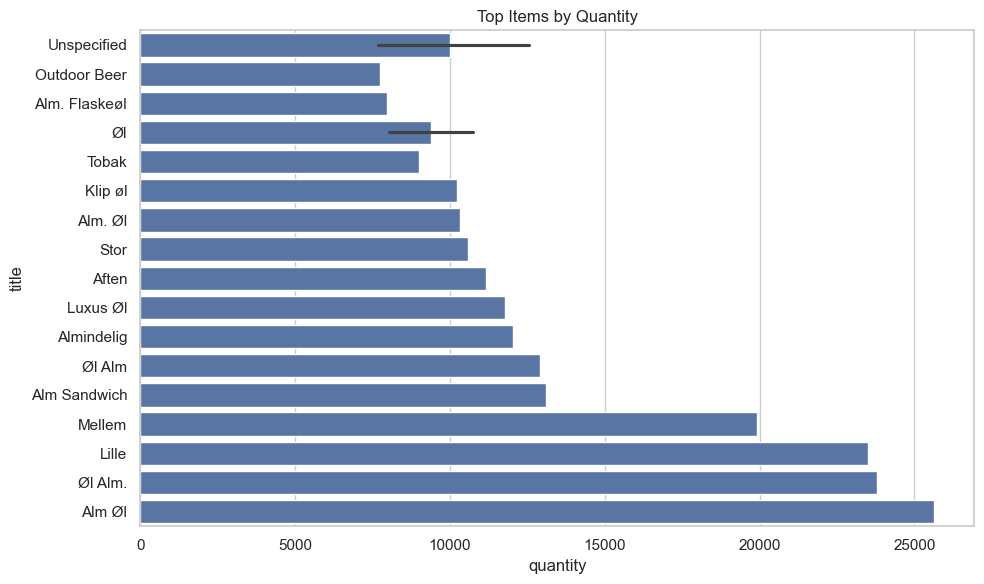

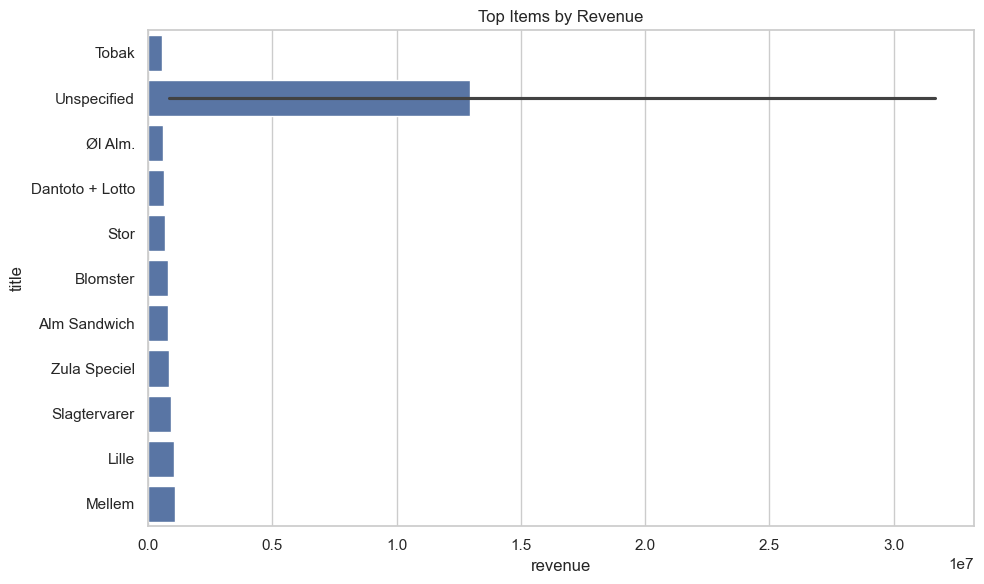

In [13]:
# Plot top items
plt.figure(figsize=(10, 6))
sns.barplot(data=top_qty.sort_values("quantity"), x="quantity", y="title")
plt.title("Top Items by Quantity")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "top_items_by_quantity.png", dpi=150)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_rev.sort_values("revenue"), x="revenue", y="title")
plt.title("Top Items by Revenue")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "top_items_by_revenue.png", dpi=150)
plt.show()

## Order items notes

- Top items by quantity are beverage-heavy (e.g., Alm Øl, Øl Alm., Lille, Mellem).
- Revenue is dominated by a few items with title `Unspecified` and very large totals; these likely need data quality checks.
- Consider grouping by `item_id` rather than `title` to avoid inconsistent naming (e.g., Alm Øl vs Alm. Øl).

## Order items (outliers removed)

Recomputes top items after removing quantity/price outliers using IQR (3x).

In [19]:
qty_sample = sample_numeric_from_csv(items_path, "quantity")
price_sample = sample_numeric_from_csv(items_path, "price")
qty_low, qty_high = iqr_bounds(qty_sample, multiplier=3.0)
price_low, price_high = iqr_bounds(price_sample, multiplier=3.0)

item_qty_f = defaultdict(float)
item_rev_f = defaultdict(float)
item_title_f = {}
item_outlier_counts = []

for chunk in pd.read_csv(items_path, chunksize=CHUNK_SIZE, low_memory=False):
    chunk = chunk.copy()
    chunk["quantity"] = pd.to_numeric(chunk.get("quantity"), errors="coerce")
    chunk["price"] = pd.to_numeric(chunk.get("price"), errors="coerce")

    inlier_mask = chunk["quantity"].between(qty_low, qty_high) & chunk["price"].between(
        price_low, price_high
    )

    item_outlier_counts.append(
        {
            "total_rows": int(len(chunk)),
            "outliers": int((~inlier_mask).sum()),
            "inliers": int(inlier_mask.sum()),
        }
    )

    filtered = chunk.loc[inlier_mask].copy()
    filtered["revenue"] = filtered["price"].fillna(0) * filtered["quantity"].fillna(0)

    ids = filtered.get("item_id")
    titles = filtered.get("title")
    for item_id, title, qty, rev in zip(
        ids, titles, filtered["quantity"], filtered["revenue"]
    ):
        if pd.isna(item_id):
            continue
        key = int(item_id) if str(item_id).isdigit() else str(item_id)
        item_qty_f[key] += float(qty) if pd.notna(qty) else 0.0
        item_rev_f[key] += float(rev) if pd.notna(rev) else 0.0
        if key not in item_title_f and pd.notna(title):
            item_title_f[key] = str(title)

items_f_df = pd.DataFrame({
    "item_id": list(item_qty_f.keys()),
    "quantity": list(item_qty_f.values()),
    "revenue": [item_rev_f[k] for k in item_qty_f.keys()],
})
items_f_df["title"] = items_f_df["item_id"].map(item_title_f)

items_f_df.to_csv(TABLES_DIR / "order_items_totals_filtered.csv", index=False)

items_f_bounds = pd.DataFrame(
    [
        {"metric": "quantity", "lower": qty_low, "upper": qty_high},
        {"metric": "price", "lower": price_low, "upper": price_high},
    ]
)
items_f_bounds.to_csv(TABLES_DIR / "order_items_outlier_bounds.csv", index=False)

pd.DataFrame(item_outlier_counts).to_csv(
    TABLES_DIR / "order_items_outlier_counts.csv", index=False
)

items_f_top_qty = items_f_df.sort_values("quantity", ascending=False).head(20)
items_f_top_rev = items_f_df.sort_values("revenue", ascending=False).head(20)
items_f_top_qty.to_csv(TABLES_DIR / "top_items_by_quantity_filtered.csv", index=False)
items_f_top_rev.to_csv(TABLES_DIR / "top_items_by_revenue_filtered.csv", index=False)

items_f_top_qty.head()

,item_id,quantity,revenue,title
5451,653549,16887.0,759915.00,Lille
5440,653567,14995.0,824725.00,Mellem
15734,754935,9215.0,719144.42,Unspecified
4858,618681,8452.0,411381.81,Unspecified
5427,653571,8066.0,524290.00,Stor


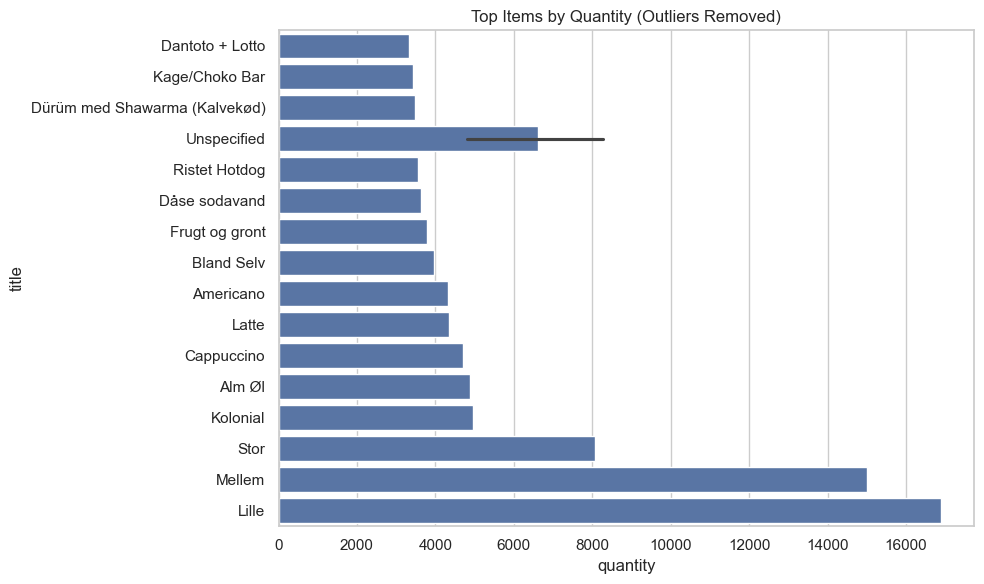

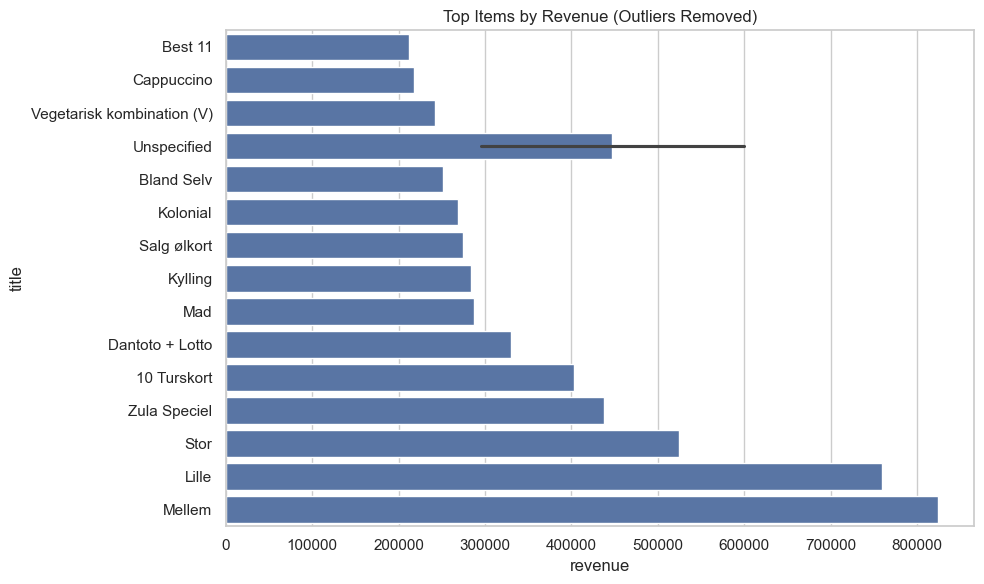

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=items_f_top_qty.sort_values("quantity"),
    x="quantity",
    y="title",
)
plt.title("Top Items by Quantity (Outliers Removed)")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "top_items_by_quantity_filtered.png", dpi=150)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=items_f_top_rev.sort_values("revenue"),
    x="revenue",
    y="title",
)
plt.title("Top Items by Revenue (Outliers Removed)")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "top_items_by_revenue_filtered.png", dpi=150)
plt.show()

In [14]:
# Item catalog summary
dim_items_path = CLEAN_DIR / "dim_items.csv"
dim_items = pd.read_csv(dim_items_path, low_memory=False)

catalog_summary = dim_items[["id", "title", "price", "status", "type"]].copy()
catalog_summary.to_csv(TABLES_DIR / "catalog_summary.csv", index=False)
catalog_summary.head()

,id,title,price,status,type
0,59837,The Classic,110.0,Active,Normal
1,59838,The Rudimental,110.0,Active,Normal
2,59839,The Garden,110.0,Active,Normal
3,59843,The Double,150.0,Active,Normal
4,59856,"Coca Cola 0,33 l",25.0,Active,Normal


## Item catalog notes

- Catalog is large (87k+ rows) with mostly `Active` items and `Normal` type.
- Prices show typical menu ranges (e.g., 25.0 for drinks, 110.0+ for mains).

## Place-level join (cross-domain)

Top places by order volume and revenue, joined to `dim_places` for names.

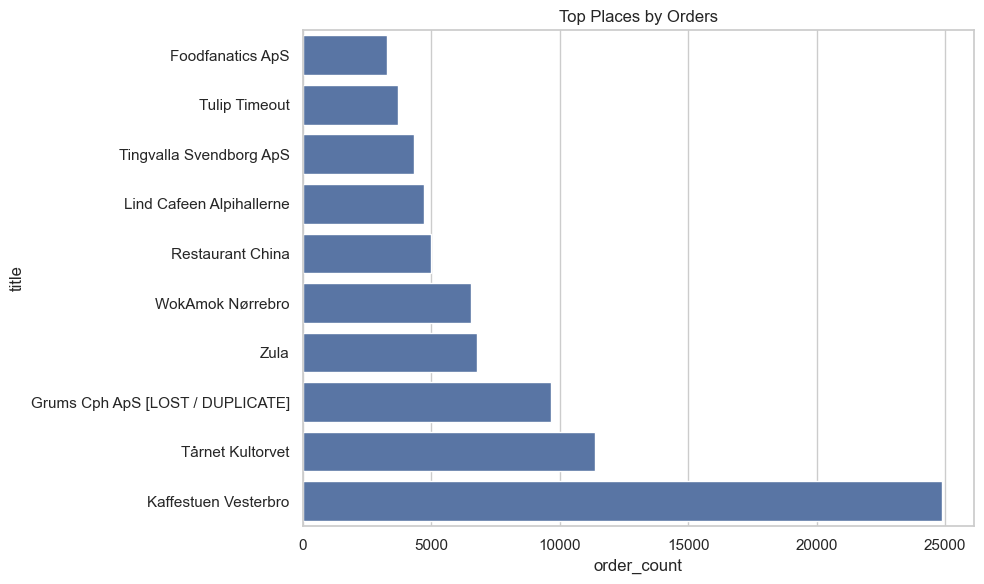

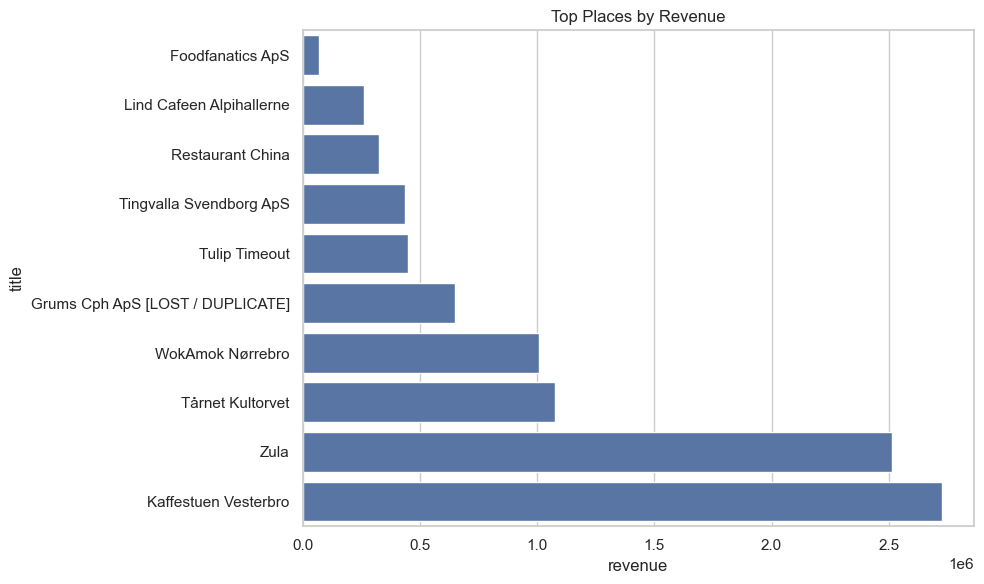

In [21]:
place_counts = defaultdict(int)
place_revenue = defaultdict(float)

for chunk in pd.read_csv(orders_path, chunksize=CHUNK_SIZE, low_memory=False):
    if "place_id" not in chunk.columns:
        continue
    chunk["total_amount"] = pd.to_numeric(chunk.get("total_amount"), errors="coerce").fillna(0)
    grouped = chunk.groupby("place_id").agg(
        order_count=("id", "count"),
        revenue=("total_amount", "sum"),
    )
    for place_id, row in grouped.iterrows():
        if pd.isna(place_id):
            continue
        key = int(place_id) if str(place_id).isdigit() else str(place_id)
        place_counts[key] += int(row["order_count"])
        place_revenue[key] += float(row["revenue"])

places_df = pd.DataFrame({
    "place_id": list(place_counts.keys()),
    "order_count": list(place_counts.values()),
    "revenue": [place_revenue[k] for k in place_counts.keys()],
})

places_dim = pd.read_csv(CLEAN_DIR / "dim_places.csv", low_memory=False)
place_name_cols = [col for col in ["id", "title"] if col in places_dim.columns]
places_dim = places_dim[place_name_cols].rename(columns={"id": "place_id"})

places_joined = places_df.merge(places_dim, on="place_id", how="left")
places_joined = places_joined.sort_values("order_count", ascending=False)

places_joined.head(20).to_csv(TABLES_DIR / "top_places_by_orders.csv", index=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=places_joined.head(20).sort_values("order_count"),
    x="order_count",
    y="title",
)
plt.title("Top Places by Orders")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "top_places_by_orders.png", dpi=150)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=places_joined.head(20).sort_values("revenue"),
    x="revenue",
    y="title",
)
plt.title("Top Places by Revenue")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "top_places_by_revenue.png", dpi=150)
plt.show()

In [15]:
# Inventory reports (may be empty)
inv_path = CLEAN_DIR / "fct_inventory_reports.csv"
inv_reports = pd.read_csv(inv_path, low_memory=False)
inv_reports.head()

,id,user_id,created,updated,end_time,excel,data,pdf,place_id,start_time


## Inventory reports notes

- The inventory report table is empty in this subset, so stock-level trends cannot be analyzed here.

## Cash balances overview

High-level stats for cash balances using chunked summaries to avoid loading the full file.

In [22]:
cash_path = CLEAN_DIR / "fct_cash_balances.csv"

cash_cols = pd.read_csv(cash_path, nrows=1).columns.tolist()

balance_col_candidates = ["balance_date_dt", "balance_date", "created_dt", "created"]
balance_col = next((col for col in balance_col_candidates if col in cash_cols), None)

value_cols = [col for col in ["opening_balance", "closing_balance", "expected_cash", "actual_cash", "variance"] if col in cash_cols]

cash_summary_rows = []

for chunk in pd.read_csv(cash_path, chunksize=CHUNK_SIZE, low_memory=False):
    if balance_col:
        dates = parse_datetime(chunk.get(balance_col), index=chunk.index)
        cash_summary_rows.append(
            {
                "min_date": dates.min(),
                "max_date": dates.max(),
            }
        )
    for col in value_cols:
        values = pd.to_numeric(chunk.get(col), errors="coerce")
        cash_summary_rows.append(
            {
                "metric": col,
                "count": int(values.notna().sum()),
                "mean": float(values.mean()) if values.notna().any() else np.nan,
                "median": float(values.median()) if values.notna().any() else np.nan,
            }
        )

cash_summary_df = pd.DataFrame(cash_summary_rows)

if balance_col and "min_date" in cash_summary_df.columns:
    min_date = cash_summary_df["min_date"].min()
    max_date = cash_summary_df["max_date"].max()
else:
    min_date = None
    max_date = None

cash_metrics = (
    cash_summary_df.dropna(subset=["metric"], how="any")
    .groupby("metric", as_index=False)
    .agg(
        count=("count", "sum"),
        mean=("mean", "mean"),
        median=("median", "mean"),
    )
)

cash_metrics["min_date"] = min_date
cash_metrics["max_date"] = max_date
cash_metrics.to_csv(TABLES_DIR / "cash_balances_summary.csv", index=False)

cash_metrics

,metric,count,mean,median,min_date,max_date
0,closing_balance,52788.0,2579.338351,1275.0,2023-10-26 05:06:53+00:00,2025-08-10 17:23:24+00:00
1,opening_balance,52915.0,2256.209663,1000.0,2023-10-26 05:06:53+00:00,2025-08-10 17:23:24+00:00


In [16]:
# Campaigns overview
campaigns_path = CLEAN_DIR / "fct_campaigns.csv"
campaigns = pd.read_csv(campaigns_path, low_memory=False)

campaigns["start_date_time_dt"] = parse_datetime(
    campaigns.get("start_date_time_dt", campaigns.get("start_date_time")),
    index=campaigns.index,
)
campaigns["end_date_time_dt"] = parse_datetime(
    campaigns.get("end_date_time_dt", campaigns.get("end_date_time")),
    index=campaigns.index,
)

campaigns_summary = campaigns[[
    "id",
    "title",
    "status",
    "type",
    "start_date_time_dt",
    "end_date_time_dt",
    "place_id",
]]
campaigns_summary.to_csv(TABLES_DIR / "campaigns_summary.csv", index=False)
campaigns_summary.head()

,id,title,status,type,start_date_time_dt,end_date_time_dt,place_id
0,60594,15% discount on Snickerskage,Inactive,Discount on specific menu items,2021-02-08 21:18:26+00:00,2021-02-15 21:18:26+00:00,59897
1,60609,10% discount on Burger,Inactive,Discount on specific menu items,2021-02-09 13:00:00+00:00,2021-02-09 16:00:00+00:00,59897
2,60610,2 for 1 on Organic Homemade Shakes,Inactive,2 for 1 on specific menu items,2021-02-08 21:39:28+00:00,2021-02-10 21:39:28+00:00,59821
3,60611,15% discount on Burgers,Inactive,Discount on specific menu items,2021-02-09 12:00:00+00:00,2021-02-09 14:00:00+00:00,59821
4,61343,15% discount on total bill,Inactive,Discount on total bill,2021-02-25 14:00:00+00:00,2021-02-25 16:00:00+00:00,59821


## Campaign notes

- Campaigns are mostly `Inactive` and concentrated around 2021 in this subset.
- Common types are percentage discounts, total-bill discounts, and freebies.
- Useful as binary promo features for forecasting if aligned to order dates and place_id.

## Most ordered summary

Sanity check of the pre-aggregated `most_ordered` view.

In [23]:
most_ordered_path = CLEAN_DIR / "most_ordered.csv"
most_ordered = pd.read_csv(most_ordered_path, low_memory=False)

most_ordered_summary = most_ordered.describe(include="all")
most_ordered_summary.to_csv(TABLES_DIR / "most_ordered_summary.csv")

most_ordered.head()

,place_id,store_address,device_serial,device_product,item_id,item_name,order_count
0,59813,NaN,NaN,NaN,60067,Knækbrød,10
1,59813,NaN,NaN,NaN,67188,Salt mandler,7
2,59813,NaN,NaN,NaN,67190,Marinerede oliven,7
3,59813,NaN,NaN,NaN,67192,Rå-marinerede asparges salat,7
4,59813,NaN,NaN,NaN,67194,Fyldte tomater med basilikum-quinoa,14
